In [2]:
import json
import numpy as np
import pandas as pd

from tqdm import tqdm
import sys
sys.path.append("..")
from eval.eval_utils import *

eval_data = json.load(open("/home/pcarragh/dev/webqa/MultiModalQA/data/WebQA_train_val_obj_v2.json", "r"))
eval_data = {k: v for k, v in eval_data.items() if v['Qcate'].lower() == 'yesno'}
perturbation_path = "/home/pcarragh/dev/webqa/image_gen_val/val_images_perturbed_gpt_obj_lama"
use_split = False
save = False
keys = list(eval_data.keys())
version = "1"

model_path = "Qwen/Qwen2-VL-7B-Instruct" #Qwen/Qwen2-VL-72B-Instruct-AWQ
model, processor = get_model_processor(model_path)
conversational_prompt = not 'Phi' in model_path

results = {}
output_file = "qa_check_counterfactuals"
with open(f"data/{output_file}_v{version}.csv", "w") as f:
    f.write("model,question_id,image_id,qa_check\n")

qa_check_answers = {}
for k in tqdm(keys): 
    example = eval_data[k]
    qa_check_answers[k] = {}
    for img in example['img_posFacts']:
        original_image_file = str(img['image_id'])
        counterfactual_image_file = f"{perturbation_path}/{original_image_file}_{k}.jpeg"
        
        question = f"Q: was the {example['Q_obj']} from the original image removed in the perturbed image?"
        messages = get_qa_check_prompt(question, conversational_prompt)
        try:
            images = get_images([original_image_file, counterfactual_image_file])
        except Exception as e:
            # print(f"Error: {e}")
            continue
        qa_check = run_inference(messages, images, processor, model, conversational_prompt)    
        qa_check_answers[k][original_image_file] = qa_check
        with open(f"data/{output_file}_v{version}.csv", "a") as f:
            f.write(f"{model_path},{k},{original_image_file},{qa_check}\n")
                

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading model from Qwen/Qwen2-VL-7B-Instruct
Qwen2VLForConditionalGeneration


  0%|          | 0/7320 [00:00<?, ?it/s]/home/pcarragh/miniconda3/envs/lmms-finetune/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.01` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/pcarragh/miniconda3/envs/lmms-finetune/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.001` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/pcarragh/miniconda3/envs/lmms-finetune/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:623: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `1` -- this flag is only used in sample-based generation modes. You should set `do_sampl

KeyboardInterrupt: 

In [3]:
# compare perturbed and original image side by side
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

def capitalize_word_in_sentence(sentence, word):
    sentence = sentence.split()
    for i, w in enumerate(sentence):
        if w.lower() == word.lower():
            sentence[i] = w.upper()
    return ' '.join(sentence)

def image_equals(img1, img2):
    if img1.size != img2.size:
        return "Wrong size"
    return np.allclose(np.array(img1), np.array(img2))

def display_images(image1, image2, q, segment_prompt, infill_prompt, save=True):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    # reduce image dimensions to fit in plot    
    ax[0].imshow(image1)
    # ax[1].imshow(mask)
    ax[1].imshow(image2)
    ax[0].set_title(segment_prompt)
    ax[1].set_title(infill_prompt)
    plt.suptitle(q, fontsize = 17)
    # remove gap between title and images
    plt.subplots_adjust(top=0.9, wspace=0.03)
    # plt.tight_layout(rect=[0, 0, 1, 0.9])
    for a in ax:
        a.axis('off')
    if save:
        plt.savefig(f"examples/{infill_prompt}_perturbed.png", bbox_inches='tight', dpi=300)    
    plt.show()

perturbation_detected_keys = [(k, img_id) for k,imgs in qa_check_answers.items() for img_id,ans in imgs.items() if 'yes' in ans.lower()]
perturbation_undetected_keys = [(k, img_id) for k,imgs in qa_check_answers.items() for img_id,ans in imgs.items() if 'no' in ans.lower()]

Wrong size

You are a helpful assistant.
user
Caption: original imageCaption: perturbed imageQ: was the Support pillars from the original image removed in the perturbed image?
assistant
No, the support pillars from the original image were not removed in the perturbed image.


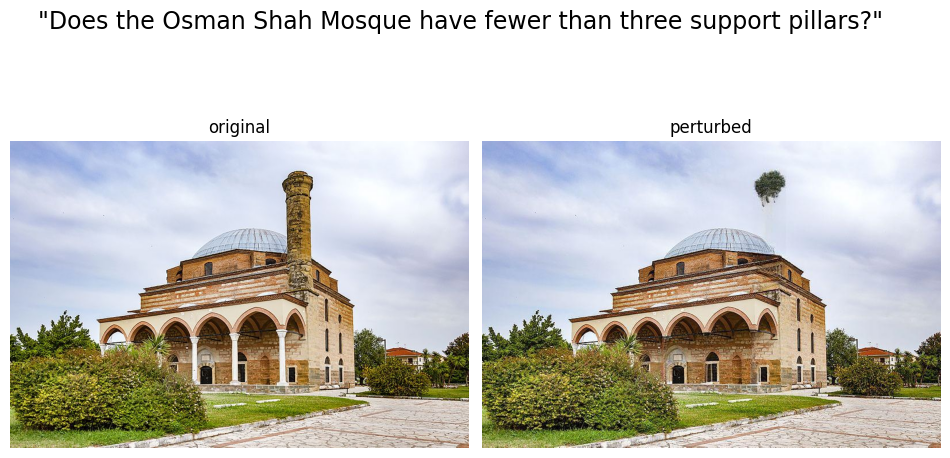

In [26]:
# example_keys = [(k, id) for k, id in perturbation_detected_keys if len(eval_data[k]['img_posFacts']) == 1]
example_keys = perturbation_undetected_keys

key, image_id = example_keys[random.randint(0, len(example_keys))]
imgs = get_images([image_id, f"{perturbation_path}/{str(image_id)}_{key}.jpeg"])
q = capitalize_word_in_sentence(eval_data[key]['Q'], eval_data[key]['Q_obj'])

print(image_equals(imgs[0], imgs[1]))
print(qa_check_answers[key][image_id])
display_images(imgs[0], imgs[1], q, "original", "perturbed", save=False)

In [24]:
perturbation_undetected_keys

[('d5bbc7c80dba11ecb1e81171463288e9', '30079629'),
 ('d5bbe94c0dba11ecb1e81171463288e9', '30235414'),
 ('d5bc623c0dba11ecb1e81171463288e9', '30349689'),
 ('d5bd5dc20dba11ecb1e81171463288e9', '30232299'),
 ('d5bd857c0dba11ecb1e81171463288e9', '30114272'),
 ('d5bd9b700dba11ecb1e81171463288e9', '30352644'),
 ('d5bda2640dba11ecb1e81171463288e9', '30306848'),
 ('d5bdb9c00dba11ecb1e81171463288e9', '30196512'),
 ('d5bdb9c00dba11ecb1e81171463288e9', '30133328'),
 ('d5bdc5e60dba11ecb1e81171463288e9', '30307282'),
 ('d5bdc5e60dba11ecb1e81171463288e9', '30071357'),
 ('d5bdf3a40dba11ecb1e81171463288e9', '30331273'),
 ('d5bdf3a40dba11ecb1e81171463288e9', '30254898'),
 ('d5be0dda0dba11ecb1e81171463288e9', '30019329'),
 ('d5be0dda0dba11ecb1e81171463288e9', '30267393'),
 ('d5be696a0dba11ecb1e81171463288e9', '30302675'),
 ('d5be8ee00dba11ecb1e81171463288e9', '30097474'),
 ('d5bf047e0dba11ecb1e81171463288e9', '30059001'),
 ('d5bf10d60dba11ecb1e81171463288e9', '30105628')]

In [13]:
example_keys

[('d5bcce700dba11ecb1e81171463288e9', '30334466'),
 ('d5bdf3a40dba11ecb1e81171463288e9', '30254898')]

In [209]:
# print(len(perturbation_detected_keys))
# # dump keys to csv
# import csv
# with open(f"results/counterfactual_qa_check.csv", "w") as f:
#     writer = csv.writer(f)
#     writer.writerows(perturbation_detected_keys)

787


: 